In [77]:
import paddle
import numpy as np
import paddle.nn as nn
from paddle.vision.datasets import Cifar10 as CIFAR10
from paddle.vision.datasets import Cifar100 as CIFAR100
from paddle.vision.datasets import MNIST
from paddle.vision import transforms
from paddle import optimizer as optim
import paddle.nn.functional as F

import os
import logging
from paddle.io import DataLoader

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [78]:
class Swish(nn.Layer):  # Swish(x) = x∗σ(x)
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * F.sigmoid(input)


class ConvNet(nn.Layer):
    def __init__(self, channel=3, num_classes=10, net_width=128, net_depth=3, net_act='relu', net_norm='instancenorm',
                 net_pooling='avgpooling', im_size=(32, 32)):
        super(ConvNet, self).__init__()

        self.features, shape_feat = self._make_layers(channel, net_width, net_depth, net_norm, net_act, net_pooling,
                                                      im_size)
        num_feat = shape_feat[0] * shape_feat[1] * shape_feat[2]
        self.classifier1 = nn.Linear(num_feat, 256)
        self.classifier2 = nn.Linear(256, num_classes)
        self.flatten = paddle.nn.Flatten()

    def forward(self, x):
        h = self.features(x)
        
        _out = self.flatten(h)
        x = self.classifier1(_out)
        y = self.classifier2(x)
        return h, x, y

    def embed(self, x):
        _out = self.features(x)
        _out = self.flatten(_out)
        return _out

    def _get_activation(self, net_act):
        if net_act == 'sigmoid':
            return nn.Sigmoid()
        elif net_act == 'relu':
            return nn.ReLU()
        elif net_act == 'leakyrelu':
            return nn.LeakyReLU(negative_slope=0.01)
        elif net_act == 'swish':
            return Swish()
        else:
            exit('unknown activation function: %s' % net_act)

    def _get_pooling(self, net_pooling):
        if net_pooling == 'maxpooling':
            return nn.MaxPool2D(kernel_size=2, stride=2)
        elif net_pooling == 'avgpooling':
            return nn.AvgPool2D(kernel_size=2, stride=2)
        elif net_pooling == 'none':
            return None
        else:
            exit('unknown net_pooling: %s' % net_pooling)

    def _get_normlayer(self, net_norm, shape_feat):
        # shape_feat = (c*h*w)
        if net_norm == 'batchnorm':
            return nn.BatchNorm2D(shape_feat[0])
        elif net_norm == 'layernorm':
            return nn.LayerNorm(shape_feat)
        elif net_norm == 'instancenorm':
            return nn.GroupNorm(shape_feat[0], shape_feat[0])
        elif net_norm == 'groupnorm':
            return nn.GroupNorm(4, shape_feat[0])
        elif net_norm == 'none':
            return None
        else:
            exit('unknown net_norm: %s' % net_norm)

    def _make_layers(self, channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size):
        layers = []
        in_channels = channel
        if im_size[0] == 28:
            im_size = (32, 32)
        shape_feat = [in_channels, im_size[0], im_size[1]]
        for d in range(net_depth):
            layers += [nn.Conv2D(in_channels=in_channels, out_channels=net_width, kernel_size=3, padding=3 if channel == 1 and d == 0 else 1)]
            shape_feat[0] = net_width
            if net_norm != 'none':
                layers += [self._get_normlayer(net_norm, shape_feat)]
            layers += [self._get_activation(net_act)]
            in_channels = net_width
            if net_pooling != 'none':
                layers += [self._get_pooling(net_pooling)]
                shape_feat[1] //= 2
                shape_feat[2] //= 2

        return nn.Sequential(*layers), shape_feat




In [79]:
def load_cifar10_data(datadir):

    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    # data prep for test set
    transform_test = transforms.Compose([transforms.ToTensor()])

    cifar10_train_ds = CIFAR10(data_file=os.path.join(datadir, 'cifar-10-python.tar.gz'), mode='train', transform=transform_train)
    cifar10_test_ds = CIFAR10(data_file=os.path.join(datadir, 'cifar-10-python.tar.gz'), mode='test', transform=transform_test)

    Train_data = cifar10_train_ds.data
    Test_data = cifar10_test_ds.data
    X_train,y_train = np.array([x[0] for x in Train_data]), np.array([x[1] for x in Train_data])
    X_test,y_test = np.array([x[0] for x in Test_data]), np.array([x[1] for x in Test_data])
    
    return (cifar10_train_ds,cifar10_test_ds,X_train,y_train,X_test,y_test)

def load_mnist_data():

    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(28),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    # data prep for test set
    transform_test = transforms.Compose([transforms.ToTensor()])

    mnist_train_ds = MNIST(mode='train', transform=transform_train)
    mnist_test_ds = MNIST(mode='test', transform=transform_test)

    X_train,y_train = np.array([x[0] for x in mnist_train_ds]), np.array([x[1][0] for x in mnist_train_ds])
    X_test,y_test = np.array([x[0] for x in mnist_test_ds]), np.array([x[1][0] for x in mnist_test_ds])
    
    return (mnist_train_ds,mnist_test_ds,X_train,y_train,X_test,y_test)

def load_cifar100_data(datadir):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
    # data prep for test set
    transform_test = transforms.Compose([transforms.ToTensor()])

    cifar100_train_ds = CIFAR100(data_file=os.path.join(datadir, 'cifar-100-python.tar.gz'), mode='train', transform=transform_train)
    cifar100_test_ds = CIFAR100(data_file=os.path.join(datadir, 'cifar-100-python.tar.gz'), mode='test', transform=transform_test)

    Train_data = cifar100_train_ds.data
    Test_data = cifar100_test_ds.data

    X_train,y_train = np.array([x[0] for x in Train_data]), np.array([x[1] for x in Train_data])
    X_test,y_test = np.array([x[0] for x in Test_data]), np.array([x[1] for x in Test_data])

    return (cifar100_train_ds,cifar100_test_ds,X_train,y_train,X_test,y_test)

def record_net_data_stats(y_train, net_dataidx_map, logdir):

    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    logger.info('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts
def partition_data(dataset, datadir, logdir, partition, n_parties, beta=0.4):
    if dataset == 'cifar10':
        _,_,X_train,y_train,X_test,y_test = load_cifar10_data(datadir)
        class_total_num = 10
    elif dataset == 'cifar100':
        _,_,X_train,y_train,X_test,y_test = load_cifar100_data(datadir)
        class_total_num = 100
    elif dataset == 'mnist':
        _,_,X_train,y_train,X_test,y_test = load_mnist_data()
        class_total_num = 10

    n_train = y_train.shape[0]

    if partition == "homo":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}

    elif partition == "noniid-labeldir":
        min_size = 0
        min_require_size = 10
        N = len(y_train)
        #np.random.seed(2020)
        net_dataidx_map = {}

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(n_parties)]
            for k in range(class_total_num):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(beta, n_parties))
                # logger.info("proportions1: ", proportions)
                # logger.info("sum pro1:", np.sum(proportions))
                ## Balance
                proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])
                # logger.info("proportions2: ", proportions)
                proportions = proportions / proportions.sum()
                # logger.info("proportions3: ", proportions)
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                # logger.info("proportions4: ", proportions)
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])
                # if K == 2 and n_parties <= 10:
                #     if np.min(proportions) < 200:
                #         min_size = 0
                #         break
        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    net_dataidx_map_ = {i:[[] for j in range(class_total_num)] for i in range(n_parties)}
    for i in range(n_parties):
        for j in net_dataidx_map[i]:
            idx = y_train[j]
            net_dataidx_map_[i][idx].append(j)
    return (X_train, y_train, X_test, y_test, net_dataidx_map, net_dataidx_map_, traindata_cls_counts)



In [80]:
seed = 0
np.random.seed(seed)
beta=0.5
dataset = 'mnist'

if dataset == 'cifar100':
    data_path = '../data/data152750'
    real_client_num = 10
    vir_clients_num = 10
    class_num=100
    num_per_class=500
    ch = 3
elif dataset == 'cifar10':
    data_path = '../data/data152754'
    real_client_num = 10
    vir_clients_num = 10
    class_num=10
    num_per_class=5000
    ch = 3
elif dataset == 'mnist':
    data_path = ""
    real_client_num = 10
    vir_clients_num = 10
    class_num=10
    num_per_class=6000
    ch = 1

X_train, y_train, X_test, y_test, net_dataidx_map, net_dataidx_map_, traindata_cls_counts = partition_data(
    dataset, data_path, 'logdir_test', 'noniid-labeldir', real_client_num, beta=beta)

INFO:root:Data statistics: {0: {0: 602, 2: 796, 3: 948, 4: 477, 5: 120, 6: 546, 7: 191, 8: 143, 9: 1650}, 1: {0: 820, 1: 2411, 2: 2824}, 2: {0: 770, 1: 25, 2: 669, 3: 963, 4: 2734, 5: 28, 6: 7, 7: 16, 8: 602, 9: 663}, 3: {0: 237, 1: 923, 2: 396, 3: 273, 4: 609, 5: 240, 6: 468, 7: 150, 8: 2975}, 4: {0: 241, 1: 409, 2: 58, 3: 1175, 4: 425, 5: 64, 6: 88, 7: 55, 8: 100, 9: 670}, 5: {0: 103, 1: 356, 3: 10, 4: 474, 5: 29, 6: 2121, 7: 554, 8: 888, 9: 2934}, 6: {0: 1430, 1: 2487, 2: 58, 3: 266, 4: 650, 5: 551, 6: 128, 7: 2929}, 7: {0: 554, 1: 1, 2: 160, 3: 51, 5: 1511, 6: 2451, 7: 1609}, 8: {0: 234, 1: 100, 2: 867, 3: 1177, 4: 77, 5: 2396, 6: 92, 7: 646, 8: 1133}, 9: {0: 932, 1: 30, 2: 130, 3: 1268, 4: 396, 5: 482, 6: 17, 7: 115, 8: 10, 9: 32}}


In [81]:
# each class total num of data
su = [0 for _ in range(class_num)]
for x in traindata_cls_counts.values():
    for i in range(class_num):
        try:
            su[i]+=x[i]
        except:
            continue
su

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [82]:
# each client total data
cl = [0 for _ in range(real_client_num)]
for idx,client in net_dataidx_map.items():
    cl[idx]+=len(client)
cl

[5473, 6055, 6477, 6271, 3285, 7469, 8499, 6337, 6722, 3412]

In [83]:
dataloader_virtual_matrix = [[[] for j in range(real_client_num)] for i in range(vir_clients_num)]
dataloader_virtual_matrix_dl = [[] for i in range(vir_clients_num)]
# dataloader_virtual_matrix

In [84]:
level = int(num_per_class / vir_clients_num)
for virtual_th in range(vir_clients_num):
    current_level = [level for i in range(class_num)]
    for client_th in range(real_client_num):
        for i in range(class_num):
            temp = current_level[i]
            dataloader_virtual_matrix[virtual_th][client_th].extend(net_dataidx_map_[client_th][i][:current_level[i]])
            current_level[i] -= len(net_dataidx_map_[client_th][i][:current_level[i]])
            net_dataidx_map_[client_th][i][:temp] = []
            # debug
            # print("client:{0} class:{1} has {2}".format(client_th, i, len(net_dataidx_map_[client_th][i])))
# dataloader_virtual_matrix


In [85]:
net_dataidx_map_
# all empty is right

{0: [[], [], [], [], [], [], [], [], [], []],
 1: [[], [], [], [], [], [], [], [], [], []],
 2: [[], [], [], [], [], [], [], [], [], []],
 3: [[], [], [], [], [], [], [], [], [], []],
 4: [[], [], [], [], [], [], [], [], [], []],
 5: [[], [], [], [], [], [], [], [], [], []],
 6: [[],
  [9069,
   13947,
   49697,
   15271,
   24895,
   59460,
   14834,
   16565,
   46204,
   10885,
   55397,
   11634,
   46949,
   33937,
   36687,
   4190,
   747,
   44158,
   13106,
   32710,
   46842,
   48949,
   50150,
   44677,
   34749,
   42806,
   18116,
   38847,
   38454,
   41536,
   57272,
   5630,
   57160,
   49488,
   33279,
   37741,
   1942,
   10318,
   25473,
   54946,
   8087,
   33091,
   54269,
   47535,
   40007,
   52205,
   4900,
   33998,
   36457,
   22931,
   112,
   4942,
   9910,
   56831,
   40525,
   40362,
   19304,
   33556,
   28153,
   16086,
   49852,
   30337,
   34725,
   21272,
   30148,
   8839,
   52359,
   56189,
   23970,
   57095,
   10541,
   17782,
   26238

In [86]:
def get_dataloader(dataset, datadir, train_bs, test_bs, dataidxs=None, is_test=False):
    if dataset in ('mnist', 'femnist', 'fmnist', 'cifar10', 'svhn', 'generated', 'covtype', 'a9a', 'rcv1', 'SUSY','cifar100'):
        if dataset == 'cifar10':
            train_ds,_,_,_,_,_ = load_cifar10_data(datadir)
            if dataidxs is not None:
                train_ds = [train_ds[i] for i in dataidxs]
            if is_test:
                _,test_ds,_,_,_,_ = load_cifar10_data(datadir)
        elif dataset == 'cifar100':
            train_ds,_,_,_,_,_ = load_cifar100_data(datadir)
            if dataidxs is not None:
                train_ds = [train_ds[i] for i in dataidxs]
            if is_test:
                _,test_ds,_,_,_,_ = load_cifar100_data(datadir)
        elif dataset == 'mnist':
            train_ds,_,_,_,_,_ = load_mnist_data()
            if dataidxs is not None:
                train_ds = [train_ds[i] for i in dataidxs]
            if is_test:
                _,test_ds,_,_,_,_ = load_mnist_data()
        else:
            train_ds, test_ds = None, None

        train_dl = DataLoader(dataset=train_ds, batch_size=train_bs, shuffle=True, drop_last=False)
        if is_test:
            test_dl = DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False, drop_last=False)
            return train_dl,test_dl
        else:
            return train_dl

In [93]:
def compute_accuracy(model, dataloader):
    model.eval()
    accuracies = []
    losses = []
    for batch_id, (x_data,y_data) in enumerate(dataloader()):

        y_data = paddle.to_tensor(y_data)
        if dataset != 'mnist':
            y_data = paddle.unsqueeze(y_data, 1)

        _,_,logits = model(x_data)
        loss = F.cross_entropy(logits, y_data)
        acc = paddle.metric.accuracy(logits, y_data)
        accuracies.append(acc.numpy())
        losses.append(loss.numpy())

    avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)

    return avg_acc

In [88]:
sum_ = 0
for net in traindata_cls_counts.values():
    try:
        sum_ += net[0]
    except:
        continue
print(f'each class total num:[{sum_}], set virtual_client_num:[10], per:[{int(sum_/10)}]')

each class total num:[5923], set virtual_client_num:[10], per:[592]


In [89]:
for virtual_client_dl_idx in range(len(dataloader_virtual_matrix)):
    for real_client_dl_idx in dataloader_virtual_matrix[virtual_client_dl_idx]:
        if real_client_dl_idx == []:
            dataloader_virtual_matrix_dl[virtual_client_dl_idx].append([])
            continue
        train_dl_local= get_dataloader(dataset, data_path, 64, 32, real_client_dl_idx, is_test=False)
        dataloader_virtual_matrix_dl[virtual_client_dl_idx].append(train_dl_local)

In [90]:
dataloader_virtual_matrix_dl

[[<paddle.fluid.reader.DataLoader at 0x7fbc95315ad0>,
  [],
  [],
  []],
  [],
  []],
  [],
  [],
  []],
 [[],
  [],
  []],
 [[],
  []],
 [[],
  []],
 [[],
  []],
 [[],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
 [[],
  [],
  [],
  [],
  [],

In [94]:
import time

args_optimizer = 'sgd'
lr = 0.01
reg = 5e-4
acc_list = []
rounds = 20
epochs = 10

net = ConvNet(channel=ch, num_classes=class_num, net_width=128, net_depth=3, net_act='relu', net_norm='instancenorm', net_pooling='avgpooling', im_size=(32, 32))

_,test_dl = get_dataloader(dataset, data_path, 64, 32, is_test=True)


if args_optimizer == 'adam':
    optimizer = optim.Adam(parameters=net.parameters(), learning_rate=lr, weight_decay=reg)
else:
    optimizer = optim.SGD(parameters=net.parameters(), learning_rate=lr, weight_decay=reg)




In [95]:
for rd in range(rounds):
    rd_time = time.time()
    virtual_id = 0
    for virtual_client_dl in dataloader_virtual_matrix_dl:
        for epoch in range(epochs):
            ep_time = time.time()
            for train_dl_local in virtual_client_dl:
                if train_dl_local == []:
                    continue
                for batch_idx, (x, target) in enumerate(train_dl_local()):
                    _, _, out = net(x)
                    loss = F.cross_entropy(out, target)

                    loss.backward()
                    optimizer.step()
                    optimizer.clear_grad()
            print("round::{0}, virtual_client::{1}, epoch::{2}, loss::{3}, elps_time::{4}.".format(rd,virtual_id,epoch,loss.item(),time.time()-ep_time))
        virtual_id += 1
    acc = compute_accuracy(net, test_dl)
    acc_list.append(acc)
    print("round::{0} finished, test_acc::{1}, elpsed time::{2}".format(rd,acc,time.time()-rd_time))

round::0, virtual_client::0, epoch::0, loss::0.005617660935968161, elps_time::1.015599250793457.
round::0, virtual_client::0, epoch::1, loss::0.019943634048104286, elps_time::0.9458293914794922.
round::0, virtual_client::0, epoch::2, loss::0.006331684999167919, elps_time::0.8664422035217285.
round::0, virtual_client::0, epoch::3, loss::0.030031226575374603, elps_time::0.8944525718688965.
round::0, virtual_client::0, epoch::4, loss::0.020967215299606323, elps_time::0.8598661422729492.
round::0, virtual_client::0, epoch::5, loss::0.015225464478135109, elps_time::0.8699727058410645.
round::0, virtual_client::0, epoch::6, loss::0.05643472820520401, elps_time::0.8712093830108643.
round::0, virtual_client::0, epoch::7, loss::0.04190671443939209, elps_time::0.8693714141845703.
round::0, virtual_client::0, epoch::8, loss::0.05591640621423721, elps_time::0.8530957698822021.
round::0, virtual_client::0, epoch::9, loss::0.026932865381240845, elps_time::0.8966121673583984.
round::0, virtual_client

In [96]:
acc_list

[0.9466853,
 0.9309105,
 0.9717452,
 0.97464055,
 0.9790335,
 0.97853434,
 0.9538738,
 0.98003197,
 0.9670527,
 0.98152953,
 0.9828275,
 0.983127,
 0.9833267,
 0.9836262,
 0.9836262,
 0.9845248,
 0.9836262,
 0.9846246,
 0.98442495,
 0.9839257]

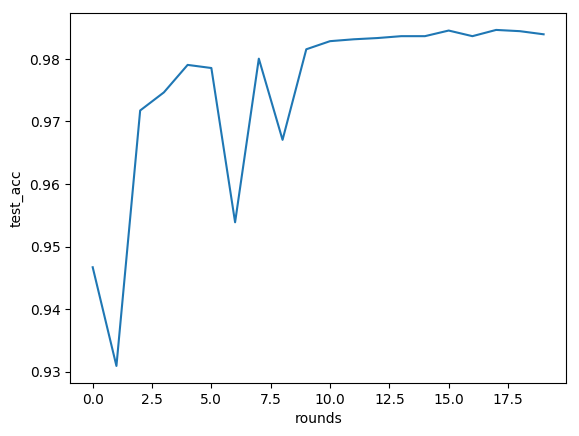

In [97]:
import matplotlib.pyplot as plt
plt.plot(range(len(acc_list)),acc_list)
plt.xlabel("rounds")
plt.ylabel("test_acc")
plt.show()

In [ ]:
# fedavg_seed0_beta_05 = [0.346146166324615,0.46675318479538,0.536541521549225,0.573682129383087,0.58316695690155,0.622603833675385,0.633386552333832,0.64367014169693,0.655051946640015,0.662739634513855,0.671625375747681,0.68140971660614,0.684205293655396,0.682208478450775,0.686900973320007,0.691293954849243,0.693390548229218,0.697683691978455,0.696984827518463]
# # fedprox_seed0_beta_05 = [0.35553115606308,0.466253995895386,0.536242008209229,0.566094219684601,0.57917332649231,0.606130182743073,0.626497626304626,0.631389796733856,0.646964848041534,0.655950486660004,0.667132616043091,0.677216470241547,0.680910527706146,0.68260782957077,0.686501622200012,0.687699675559998,0.689596652984619,0.697484016418457,0.695986449718475]
# moon_seed0_beta_05 = [0.360123813152313,0.475838661193848,0.539936125278473,0.576477646827698,0.584964036941528,0.61401754617691,0.622503995895386,0.638079047203064,0.65425318479538,0.658646166324616,0.665435314178467,0.676218032836914,0.683406531810761,0.67861419916153,0.686601459980011,0.687000811100006,0.692492008209229,0.697783529758453,0.698382616043091]
fedvir_seed0_beta_05 = [0.5548123, 0.5952476, 0.63977635, 0.6609425, 0.677516, 0.6963858, 0.7071685, 0.7157548, 0.71914935, 0.72853434, 0.73003197, 0.7345248, 0.7346246, 0.73722047, 0.73901755, 0.74021566, 0.74101436, 0.7433107, 0.74211264, 0.74271166]
plt.plot(range(19),fedavg_seed0_beta_05,label="FedAvg")
# plt.plot(range(19),fedprox_seed0_beta_05,label="FedProx")
# plt.plot(range(19),moon_seed0_beta_05,label="MOON")
plt.plot(range(20),fedvir_seed0_beta_05,label="FedVir(Ours)")
plt.xlabel("rounds")
plt.ylabel("test_acc")
plt.legend()
# # plt.savefig("fedDyn_beta05.png",dpi=330)
plt.show()

In [ ]:
fedprox_seed0_beta_05=[0.162539929151535,0.211361825466156,0.267372190952301,0.296425729990005,0.26767173409462,0.343051105737686,0.351337850093842,0.348342657089233,0.352236419916153
,0.377396166324615,0.395866602659225,0.416833072900772,0.435902565717697,0.421126186847687,0.438897758722305,0.442891359329224,0.44928115606308,0.458965659141541
,0.453474432229996]

In [ ]:
fedvir_seed0_beta_05_cifar100 = [0.319988, 0.36491615, 0.38578275, 0.39996007, 0.41134185, 0.4154353, 0.42272365, 0.4224241, 0.42501998, 0.42601836, 0.43011183, 0.4308107, 0.43190894, 0.4335064, 0.43370607, 0.43789935, 0.44029552, 0.4365016, 0.43869808, 0.4406949]

In [ ]:
fedavg_seed0_beta_05 = [0.340455263853073,0.459065496921539,0.527855455875397,0.563997626304626,0.572683691978455,0.607927322387695,0.619109451770783,0.625998377799988,0.648861825466156,0.650459289550781,0.664337038993835,0.67082667350769,0.677416145801544,0.679113447666168,0.684604644775391,0.685902535915375,0.686501622200012,0.694688498973846,0.694788336753845]
len(fedavg_seed0_beta_05)